In [3]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def Bool_to_bin(ds, col):
    ds[col] = ds[col].replace({'A':0, 'B':1})

In [6]:
def Scaler_Stand(features_,X_):
    scaler = StandardScaler()
    X_train_scaled = X_.copy()
    X_train_scaled[features_] = scaler.fit_transform(X_train_scaled[features_])
    return X_train_scaled

### Пути к директориям и файлам

In [7]:
train_ds = pd.read_csv('train.csv', index_col='Id')
test_ds = pd.read_csv('test.csv', index_col='Id')

### Информация о датасетах

In [8]:
train_ds.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [9]:
test_ds.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [10]:
train_ds.shape, test_ds.shape

((10000, 19), (5000, 18))

In [11]:
train_ds.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [12]:
test_ds.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Типы данных и проверка пропущенных элементов

In [13]:
test_ds.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [14]:
train_ds['DistrictId'] = train_ds['DistrictId'].astype(str)
test_ds['DistrictId'] = test_ds['DistrictId'].astype(str)

In [15]:
train_ds.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [16]:
test_ds.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

### Анализ целевой переменной

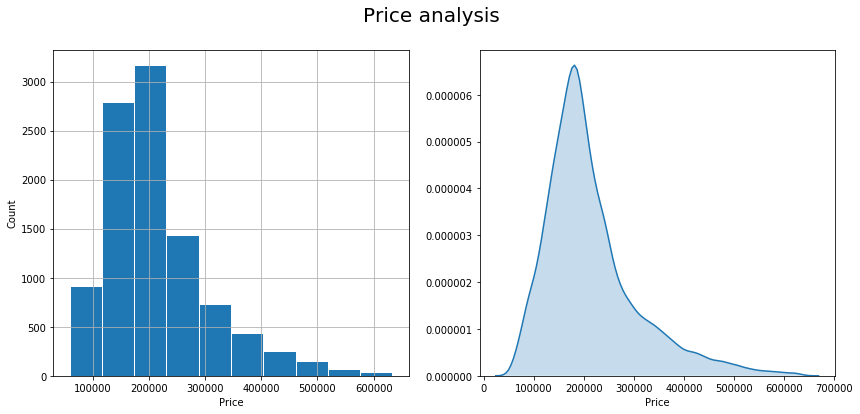

In [17]:
plt.figure(figsize = (14, 6))

plt.subplot(121)
train_ds['Price'].hist(edgecolor='white')
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_ds['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Price analysis', size=20);

In [18]:
target_mean = round(train_ds['Price'].mean(), 2)
target_median = train_ds['Price'].median()

target_mean, target_median

(214138.86, 192269.64487934904)

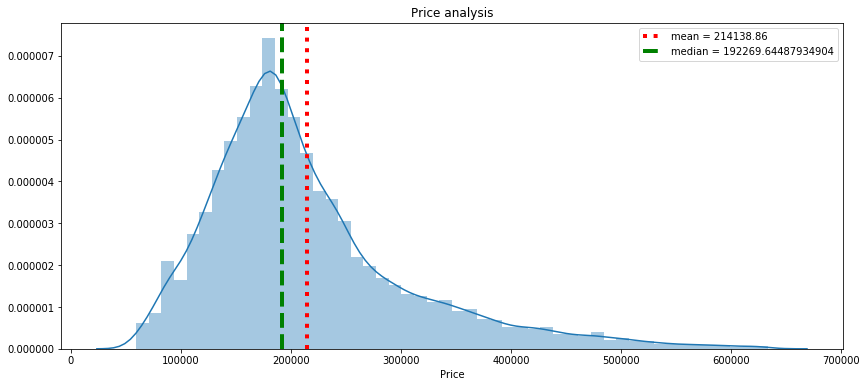

In [19]:
plt.figure(figsize = (14, 6))
sns.distplot(train_ds['Price'])
plt.title('Price analysis')
plt.axvline(target_mean, color='r', label='mean = {0}'.format(target_mean), linestyle=':', linewidth=4)
plt.axvline(target_median, color='g', label='median = {0}'.format(target_median), linestyle='--', linewidth=4)
plt.legend();

### Переменные

#### Количественные

In [22]:
feature_num_names = train_ds.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

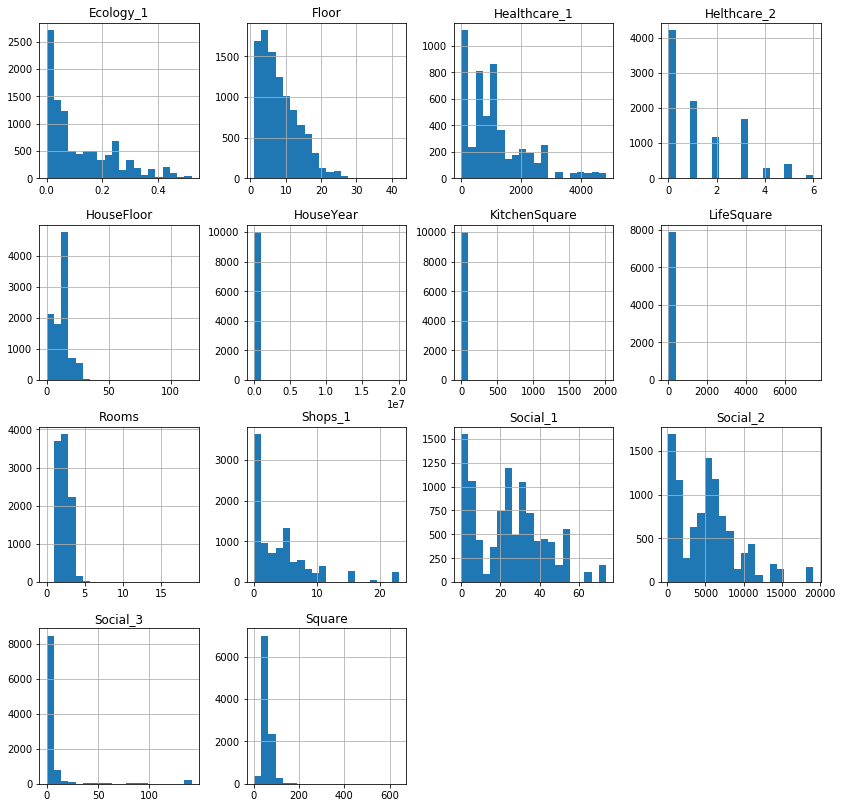

In [23]:
train_ds[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

##### Заполнение пропущенных значений в Lifesquare 

In [24]:
train_ds['LifeSquare'].isna().sum(), test_ds['LifeSquare'].isna().sum()

(2113, 1041)

In [25]:
train_ds.loc[train_ds['LifeSquare'].isna(), 'LifeSquare'] = train_ds['Square'] - train_ds['KitchenSquare']
test_ds.loc[test_ds['LifeSquare'].isna(), 'LifeSquare'] = test_ds['Square'] - test_ds['KitchenSquare']

In [26]:
train_ds['LifeSquare'].isna().sum(), test_ds['LifeSquare'].isna().sum()

(0, 0)

#### Категориальные переменные (Ecology_2, Ecology_3, Shops_2)
##### Меняем категориальные значения на бинарные

In [27]:
feature_cat_names = train_ds.select_dtypes(include='object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [28]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

In [29]:
Bool_to_bin(train_ds, feature_bin_names)
Bool_to_bin(test_ds, feature_bin_names)

In [30]:
train_ds.info(), test_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

(None, None)

In [31]:
# sns.boxplot('Price', 'Ecology_2', data=train_ds);

In [32]:
# sns.boxplot('Price', 'Ecology_3', data=train_ds);

In [33]:
# sns.boxplot('Price', 'Ecology_2', data=train_ds);

In [34]:
# sns.catplot('Price', 'Ecology_2', kind='box', data=train_ds, aspect=3/2);

In [35]:
train_ds['Healthcare_1'].fillna(train_ds['Healthcare_1'].median(), inplace=True)
test_ds['Healthcare_1'].fillna(test_ds['Healthcare_1'].median(), inplace=True)

### Корреляционная матрица

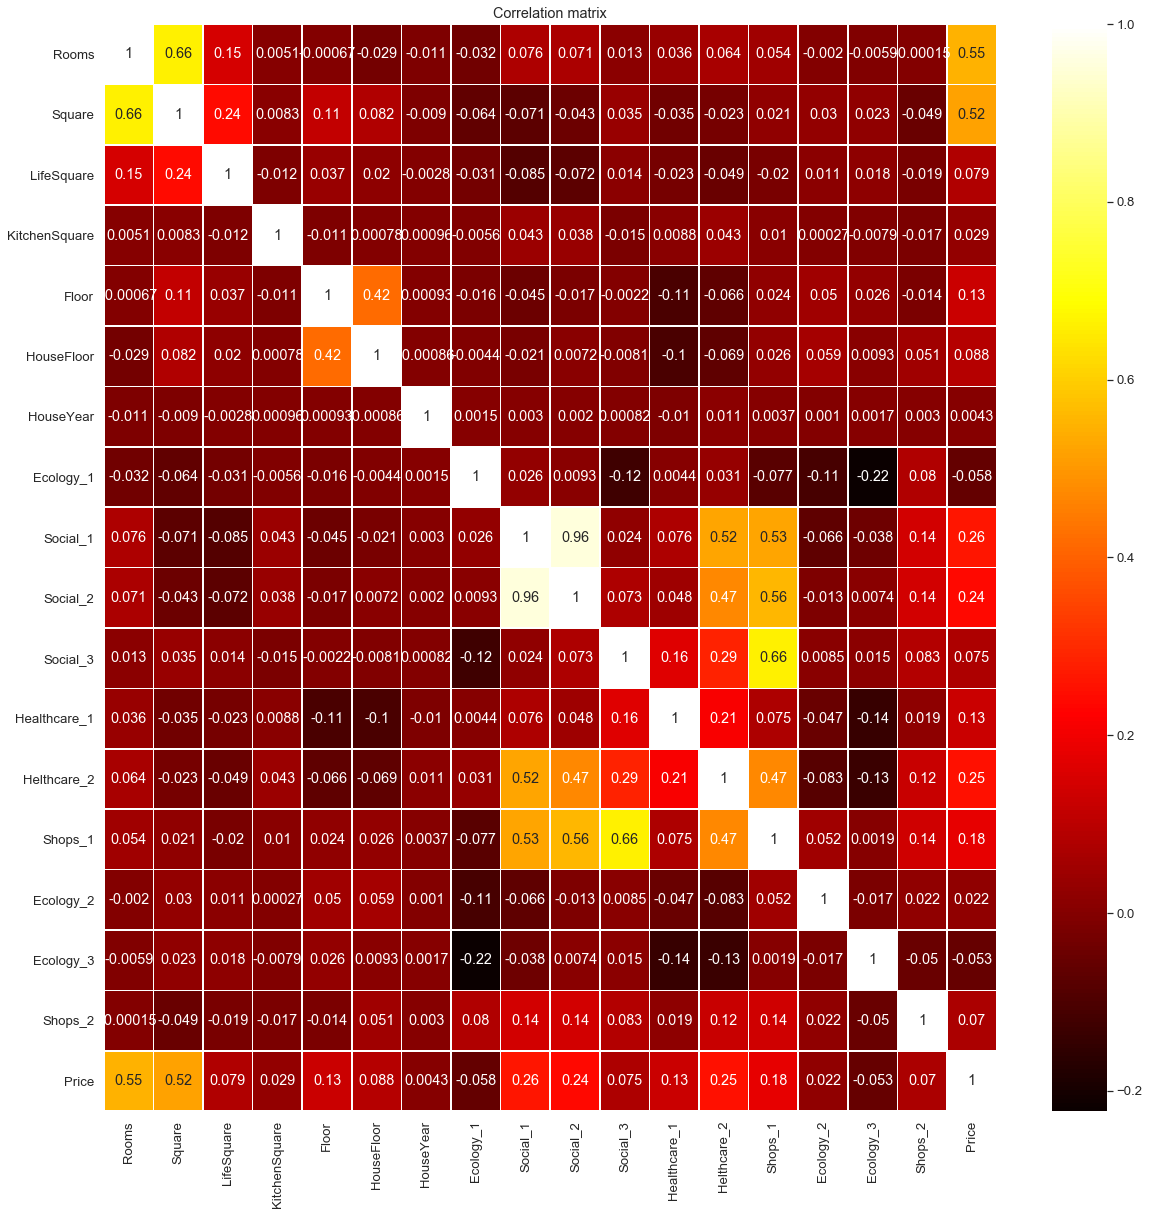

In [36]:
plt.figure(figsize = (20,20))

sns.set(font_scale=1.2)
sns.heatmap(train_ds[feature_num_names + feature_bin_names + ['Price']].corr(), 
            annot=True, linewidths=.5, cmap='hot')

plt.title('Correlation matrix');

### Обработка выбросов

In [37]:
train_ds[['Rooms']].describe()

,Rooms
count,10000.000000
mean,1.890500
std,0.839512
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,19.000000


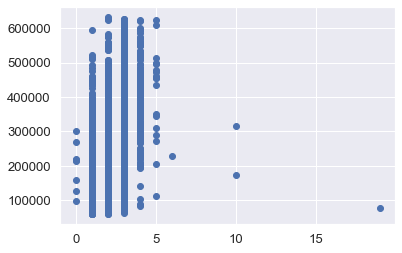

In [38]:
plt.scatter(train_ds['Rooms'], train_ds['Price']);

In [39]:
test_ds[['Rooms']].describe()

,Rooms
count,5000.000000
mean,1.910000
std,0.838594
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,17.000000


In [40]:
train_ds['Rooms'].median(), test_ds['Rooms'].median()

(2.0, 2.0)

In [41]:
train_ds.loc[(train_ds['Rooms'] > 5)|(train_ds['Rooms'] == 0), 'Rooms'] = train_ds['Rooms'].median()
test_ds.loc[(test_ds['Rooms'] > 5)|(test_ds['Rooms'] == 0), 'Rooms'] = test_ds['Rooms'].median()

In [42]:
train_ds[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.315775,41.799474,6.273300
std,21.058732,77.823543,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,25.494155,1.000000
50%,52.513310,37.040829,6.000000
75%,65.900625,49.823229,9.000000
max,641.065193,7480.592129,2014.000000


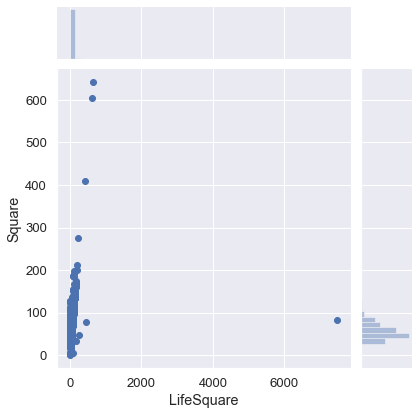

In [43]:
sns.jointplot(train_ds['LifeSquare'], train_ds['Square'], kind='scatter', height=6);

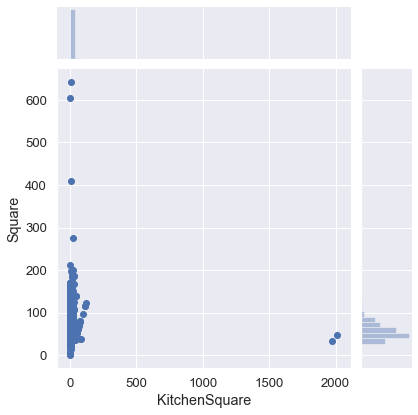

In [44]:
sns.jointplot(train_ds['KitchenSquare'], train_ds['Square'], kind='scatter', height=6);

In [45]:
train_ds.loc[(train_ds['Square'] > 250) | (train_ds['Square'] < 10), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,1,1,43,8429,3,900.0,3,9,1,412511.088764
11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,1,1,4,915,0,900.0,0,0,1,107604.269441
10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,1,137597.601458
5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,1,0,31,7010,5,4508.0,3,7,1,455264.882666
10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,1,1,9,1892,0,900.0,0,1,1,97560.720383
9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,1,369472.403061
28,9,2.0,604.705972,603.705972,1.0,17,18.0,1977,0.161532,1,1,25,5648,1,30.0,2,4,1,187717.242538
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,90470.430830
3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,900.0,0,0,1,126596.941798


In [46]:
train_ds.loc[(train_ds['LifeSquare'] > 250) | (train_ds['LifeSquare'] > train_ds['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,1,1,0,168,0,900.0,0,0,1,95338.198549
10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,1,1,1,264,0,900.0,0,1,1,199215.452229
8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,1,1,53,13670,4,900.0,1,11,1,309688.592681
9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,1,1,2,629,1,900.0,0,0,0,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,30,2.0,59.015896,59.439082,12.0,5,5.0,2016,0.000078,1,1,22,6398,141,1046.0,3,23,1,126281.142781
12918,23,2.0,51.440463,53.134243,51.0,3,17.0,2017,0.005767,1,1,1,388,0,900.0,0,0,1,88150.012510
2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,1,1,2,469,0,900.0,0,0,1,234194.837047


In [47]:
train_ds.loc[(train_ds['KitchenSquare'] > 240) | (train_ds['KitchenSquare'] > train_ds['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,900.0,0,0,0,108337.484207
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,900.0,1,0,1,160488.033165
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,900.0,0,0,1,99079.960518
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275


In [48]:
train_ds.loc[(train_ds['Square'] > 250) | (train_ds['Square'] < 10), 'Square'] = train_ds['Square'].median()

test_ds.loc[(test_ds['Square'] > 250) | (test_ds['Square'] < 10), 'Square'] = test_ds['Square'].median()

In [49]:
train_ds.loc[(train_ds['LifeSquare'] > 250) | (train_ds['LifeSquare'] > train_ds['Square']), 'LifeSquare'] = train_ds['LifeSquare'].median()

test_ds.loc[(test_ds['LifeSquare'] > 250) | (test_ds['LifeSquare'] > test_ds['Square']), 'LifeSquare'] = test_ds['LifeSquare'].median()

In [50]:
train_ds.loc[(train_ds['KitchenSquare'] > 240) | (train_ds['KitchenSquare'] > train_ds['Square']), 'KitchenSquare'] = train_ds['KitchenSquare'].median()

test_ds.loc[(test_ds['KitchenSquare'] > 240) | (test_ds['KitchenSquare'] > test_ds['Square']), 'KitchenSquare'] = test_ds['KitchenSquare'].median()

In [51]:
train_ds[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.202271,39.687569,5.861600
std,18.936795,19.181536,5.070426
min,13.784865,0.370619,0.000000
25%,41.794392,25.527399,1.000000
50%,52.513310,37.040829,6.000000
75%,65.889256,47.863414,9.000000
max,212.932361,211.231125,123.000000


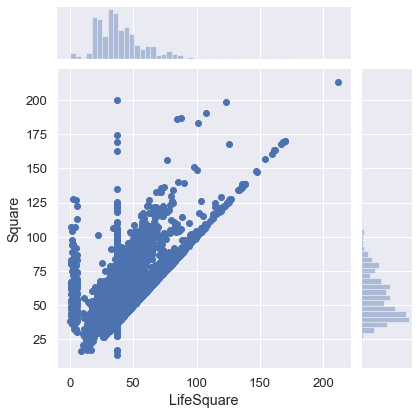

In [52]:
sns.jointplot(train_ds['LifeSquare'], train_ds['Square'], kind='scatter', height=6);

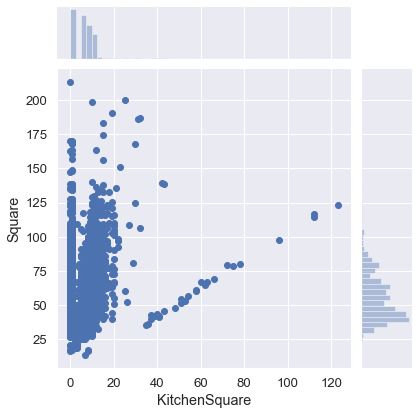

In [53]:
sns.jointplot(train_ds['KitchenSquare'], train_ds['Square'], kind='scatter', height=6);

##### Floor, HouseFloor

In [54]:
train_ds[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,10000.000000,10000.000000
mean,8.526700,12.609400
std,5.241148,6.775974
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,13.000000
75%,12.000000,17.000000
max,42.000000,117.000000


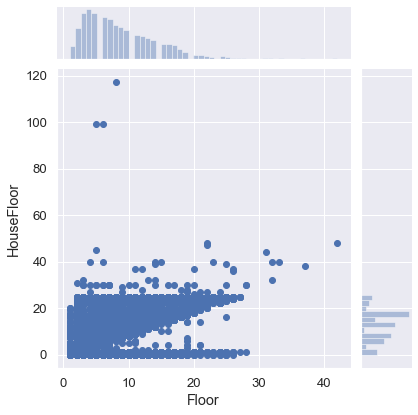

In [55]:
sns.jointplot(train_ds['Floor'], train_ds['HouseFloor'], kind='scatter', height=6);

In [56]:
train_ds.loc[(train_ds['Floor'] > train_ds['HouseFloor'] ), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.0,80.312926,80.312926,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,221244.156664
10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,140647.565937
2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,1,1,5,1227,0,900.0,0,0,1,117000.381287
11935,27,2.0,64.711835,63.711835,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,127200.026511
6641,54,3.0,118.907612,118.907612,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,571069.052600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,1,1,34,7065,1,750.0,2,5,1,226434.880156
16159,27,1.0,38.968338,37.968338,1.0,10,1.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,95529.569405
4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,1,1,53,14892,4,900.0,1,4,1,441108.911237


In [57]:
train_ds.loc[(train_ds['HouseFloor'] > 55) | (train_ds['HouseFloor'] == 0), 'HouseFloor'] = train_ds['HouseFloor'].median()

test_ds.loc[(test_ds['HouseFloor'] > 55) | (test_ds['HouseFloor'] == 0), 'HouseFloor'] = test_ds['HouseFloor'].median()

In [58]:
train_ds.loc[(train_ds['Floor'] > train_ds['HouseFloor']), 'Floor'] = train_ds['Floor'].median()

test_ds.loc[(test_ds['Floor'] > test_ds['HouseFloor']), 'Floor'] = test_ds['Floor'].median()

##### Проверка и сравнение Square и LifeSquare, KitchenSquare (должно быть Square - (LifeSquare + KitchenSquare) >= 0))

In [59]:
square_null = train_ds['Square'] - train_ds['LifeSquare'] - train_ds['KitchenSquare']

In [60]:
train_ds.loc[(square_null < 0), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
7596,23,1.0,47.080100,46.807989,12.0,3.0,9.0,1977,0.014073,1,1,2,475,0,900.0,0,0,1,96029.167877
6925,27,2.0,64.929103,63.304605,10.0,15.0,17.0,2016,0.072158,1,1,2,629,1,900.0,0,0,0,228584.001072
6072,6,1.0,65.102017,64.622603,1.0,7.0,9.0,2015,0.243205,1,1,5,1564,0,540.0,0,0,1,175899.978284
6172,27,2.0,92.400007,92.069236,10.0,2.0,5.0,1977,0.075424,1,1,11,3097,0,900.0,0,0,1,116942.671045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12918,23,2.0,51.440463,37.040829,51.0,3.0,17.0,2017,0.005767,1,1,1,388,0,900.0,0,0,1,88150.012510
2737,27,3.0,123.430072,37.040829,123.0,5.0,10.0,2015,0.017647,1,1,2,469,0,900.0,0,0,1,234194.837047
4497,1,1.0,38.330353,38.010046,8.0,7.0,17.0,1991,0.025609,1,1,33,5261,0,240.0,3,1,1,97464.327338


In [61]:
train_ds.loc[(square_null < 0), 'Square'] = train_ds['Square'] + abs(square_null)

In [62]:
square_null_test = test_ds['Square'] - test_ds['LifeSquare'] - test_ds['KitchenSquare']

In [63]:
test_ds.loc[(square_null_test < 0), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,13.597819,36.936106,12.0,2.0,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
891,85,2.0,65.550690,61.689280,10.0,13.0,22.0,1988,0.037178,1,1,52,11217,1,2300.0,1,7,1
6624,27,1.0,42.413793,36.936106,10.0,12.0,17.0,2017,0.011654,1,1,4,915,0,900.0,0,0,1
9519,62,3.0,81.912997,75.872094,11.0,3.0,6.0,2015,0.072158,1,1,2,629,1,900.0,0,0,0
5452,27,1.0,48.587913,42.596190,12.0,7.0,2.0,2016,0.017647,1,1,2,469,0,900.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,94,4.0,96.933127,96.282901,8.0,18.0,22.0,2015,0.282798,1,1,33,8667,2,900.0,0,6,1
3711,94,1.0,41.281057,36.936106,10.0,13.0,13.0,2014,0.282798,1,1,33,8667,2,900.0,0,6,1
5820,94,1.0,33.680382,36.936106,1.0,7.0,9.0,1972,0.127376,1,1,43,8429,3,900.0,3,9,1


In [64]:
test_ds.loc[(square_null_test < 0), 'Square'] = test_ds['Square'] + abs(square_null_test)

##### HouseYear

In [65]:
train_ds[['HouseYear']].describe()

,HouseYear
count,1.000000e+04
mean,3.990166e+03
std,2.005003e+05
min,1.910000e+03
25%,1.974000e+03
50%,1.977000e+03
75%,2.001000e+03
max,2.005201e+07


In [66]:
train_ds['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
6731         2020
8892         2020
14318        2020
           ...   
7920         1916
6751         1914
2085         1912
14556        1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [67]:
train_ds.loc[train_ds['HouseYear'] > 2020, 'HouseYear'] = 2020

In [68]:
test_ds[['HouseYear']].describe()

,HouseYear
count,5000.000000
mean,1984.392600
std,18.573149
min,1908.000000
25%,1973.000000
50%,1977.000000
75%,2000.000000
max,2020.000000


### Добавление уникальных признаков 

##### Цена за квадратный метр

In [69]:
train_ds['PriceMtsq'] = train_ds['Price'] / train_ds['Square']

In [70]:
train_ds['PriceMtsq'].describe()

count    10000.000000
mean      3875.243841
std       1256.889805
min        752.588644
25%       2901.534706
50%       3892.188575
75%       4682.871194
max      11854.652892
Name: PriceMtsq, dtype: float64

In [71]:
train_ds.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,PriceMtsq
Id,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,1,1,33,7976,5,900.0,0,11,1,184966.930730,3854.958571
15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063,4567.491245
4765,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524,4915.149522
5809,58,2.0,61.731512,52.731512,9.0,8.0,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217,2844.839230
10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644,3788.892642


##### Оставшаяся площадь

In [72]:
train_ds['RemainSquare'] = train_ds['Square'] - train_ds['LifeSquare'] - train_ds['KitchenSquare']
test_ds['RemainSquare'] = test_ds['Square'] - test_ds['LifeSquare'] - test_ds['KitchenSquare']

In [73]:
train_ds['RemainSquare'].describe()

count    1.000000e+04
mean     1.098721e+01
std      1.181434e+01
min     -7.105427e-15
25%      0.000000e+00
50%      9.949590e+00
75%      1.487837e+01
max      1.382937e+02
Name: RemainSquare, dtype: float64

In [74]:
test_ds.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RemainSquare
Id,,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,1,1,11,2748,1,900.0,0,0,1,10.449862
15856,74,2.0,69.263183,68.263183,1.0,7.0,1.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,0.000000
5480,190,1.0,48.936106,36.936106,12.0,2.0,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,0.000000
15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,1,1,23,4583,3,900.0,3,3,1,12.105767
14275,27,1.0,47.527111,43.387569,1.0,17.0,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,3.139541


In [75]:
train_ds.to_csv('train_prepared.csv')
test_ds.to_csv('test_prepared.csv')

### Корреляционная матрица после обработки выбросов и добавления уникальных признаков

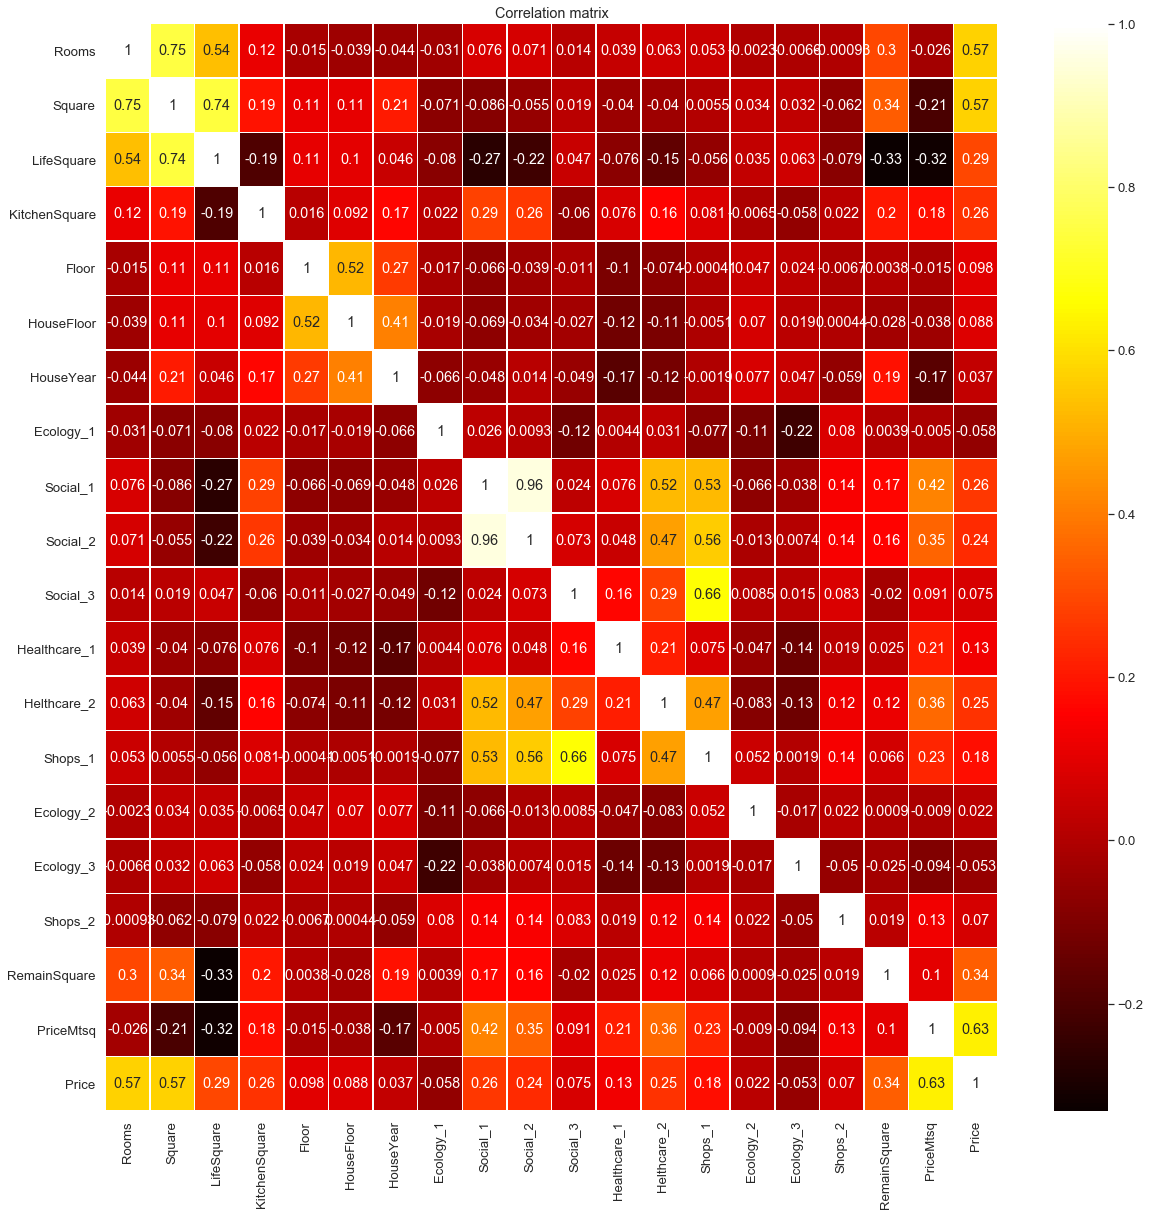

In [76]:
plt.figure(figsize = (20,20))

sns.set(font_scale=1.2)
sns.heatmap(train_ds[feature_num_names + feature_bin_names + ['RemainSquare'] + ['PriceMtsq'] + ['Price']].corr(), 
            annot=True, linewidths=.5, cmap='hot')

plt.title('Correlation matrix');

### Подготовка признаков перед построением модели

In [329]:
feature_names = train_ds.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'PriceMtsq',
 'RemainSquare']

In [330]:
target_name = ['Price']
feature_names = ['DistrictId',
                 'Rooms',
                 'Square',
                 'LifeSquare',
                 'KitchenSquare',
                 'Floor',
                 'HouseFloor',
                 'HouseYear',
#               'Ecology_1',
                 'Ecology_2',
#                 'Ecology_3',
                 'Social_1',
                 'Social_2',
#                 'Social_3',
                 'Healthcare_1',
                 'Helthcare_2',
                 'Shops_1',
#                 'Shops_2',
#                 'PriceMtsq',
                 'RemainSquare']

In [336]:
X = train_ds[feature_names]
y = train_ds[target_name]
X_test = test_ds[feature_names]

In [337]:
forest = RandomForestRegressor(max_depth=19, max_features=6, n_estimators=100, random_state=42)

In [338]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.73107


### Важность признаков

In [339]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

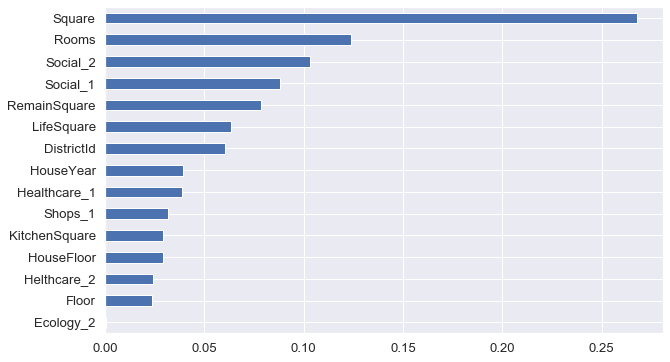

In [340]:
feat_importances.plot(kind='barh', figsize=(10, 6));

### Модель Random Forest

In [343]:
params = {'n_estimators': [400], 'max_depth': [18,19,20], 'max_features': [5,6,7]}

In [344]:
forest_grid = GridSearchCV(forest, params, scoring='r2', cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 20, 'max_features': 5, 'n_estimators': 400}
R2 на train: 0.73418


### Прогноз на тестовом датасете

In [345]:
forest_best = forest_grid.best_estimator_

In [346]:
y_pred = forest_best.predict(X_test)

In [347]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,169402.930007
1,15856,225560.113291
2,5480,289946.299725
3,15664,336475.169023
4,14275,139776.465923


In [348]:
preds.to_csv('final.csv', index=False)